<a href="https://colab.research.google.com/github/JessemanGray/Syn-Aesthetics/blob/main/Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages

import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split



In [ ]:
# Turn file path into DataFrame, show first five rows
url = "https://raw.githubusercontent.com/JessemanGray/Syn-Aesthetics/main/ChillsDB%201.0.1%20-%20Speech%20Stimuli%20(2).csv"
df = pd.read_csv(url)
df.head()

,Video ID,Age,Gender,Ethnicity,chills Binary,chills Binary.1,Chills #,Chill Intensity,Timings,Daily Chills,...,Emotion drift,Direction,Unnamed: 27,Unnamed: 28,Tan inverse,Calm Diff,Pleasure Diff,Unnamed: 32,Tan inverse.1,Unnamed: 34
0,Bg_Q7KYWG1g,26,female,White,1,True,1,2,441.44,2,...,1.118034,-0.5463024898,NaN,NaN,-0.463648,1.0,-0.5,FALSE,-0.463648,Down
1,g-jwWYX7Jlo,51,female,White,1,True,5,2,"55.32,95.56,178.68,331.87,363.07",2,...,0.707107,1.557407725,NaN,NaN,0.785398,-0.5,-0.5,Up,0.785398,Up
2,g-jwWYX7Jlo,20,female,White,1,True,1,1,359.27,1,...,1.414214,-1.557407725,NaN,NaN,-0.785398,1.0,-1.0,FALSE,-0.785398,Down
3,Bg_Q7KYWG1g,51,female,White,1,True,7,2,"119.52,129.28,137.55,160.58,355.46,447.40,482.97",2,...,1.802776,-14.10141995,NaN,NaN,-0.982794,1.0,-1.5,FALSE,-0.982794,Down
4,g-jwWYX7Jlo,26,female,White,1,True,4,2,"46.40,63.04,243.75,328.55",3,...,1.000000,0,NaN,NaN,0.000000,1.0,0.0,FALSE,0.000000,Down


In [ ]:
# Fill missing values with the mean of the column
df = df.fillna(df.mean())

<ipython-input-72-15288beba849>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [ ]:
# Check for missing values in the entire DataFrame
missing_values = df.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

Timings        24
Unnamed: 27    80
Unnamed: 28    80
dtype: int64


In [ ]:
# Chenck types before dropping
df['Timings'].dtypes

dtype('O')

In [ ]:
# Drop duplicate or unnecessary columns
df = df.drop(columns=['chills Binary.1', 'Unnamed: 32', 'Unnamed: 34', 'Unnamed: 28', 'Unnamed: 27', 'Timings'])


# Convert data types
df['chills Binary'] = df['chills Binary'].astype(bool)

# Check for correlation between 'Direction' and 'Tan inverse.1'
print(df[['Direction', 'Tan inverse.1']].corr())

               Tan inverse.1
Tan inverse.1            1.0


<ipython-input-75-e36ad79d19f0>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[['Direction', 'Tan inverse.1']].corr())


In [ ]:
# Columns with zero variance
zero_variance_columns = df.loc[:, df.nunique() == 1]
print(zero_variance_columns)

   Prior exposure
0              No
1              No
2              No
3              No
4              No
..            ...
75             No
76             No
77             No
78             No
79             No

[80 rows x 1 columns]


In [ ]:
def score(val):
    if val >= 1:
        return 3
    elif val >= 0.5:
        return 2
    elif val >= 0:
        return 1
    else:
        return 0

def classify_chill(row):
    emotion_score = score(row['Emotion drift'])
    calm_score = score(row['Calm Diff'])
    pleasure_score = score(row['Pleasure Diff'])

    # Sum the scores and normalize to a 0-10 scale
    total_score = emotion_score + calm_score + pleasure_score
    chill_rating = (total_score / 9) * 10  # 9 is the maximum total_score

    return str(round(chill_rating, 1))  # Round to 1 decimal place

df['Chill Rating'] = df.apply(classify_chill, axis=1)

In [ ]:
df.head()

,Video ID,Age,Gender,Ethnicity,chills Binary,Chills #,Chill Intensity,Daily Chills,NIO_Openess,Prior exposure,...,Post NEO,Diff NEO,Total NEO,Emotion drift,Direction,Tan inverse,Calm Diff,Pleasure Diff,Tan inverse.1,Chill Rating
0,Bg_Q7KYWG1g,26,female,White,True,1,2,2,2,No,...,15,3,27,1.118034,-0.5463024898,-0.463648,1.0,-0.5,-0.463648,6.7
1,g-jwWYX7Jlo,51,female,White,True,5,2,2,3,No,...,9,3,15,0.707107,1.557407725,0.785398,-0.5,-0.5,0.785398,2.2
2,g-jwWYX7Jlo,20,female,White,True,1,1,1,3,No,...,10,6,14,1.414214,-1.557407725,-0.785398,1.0,-1.0,-0.785398,6.7
3,Bg_Q7KYWG1g,51,female,White,True,7,2,2,2,No,...,9,4,14,1.802776,-14.10141995,-0.982794,1.0,-1.5,-0.982794,6.7
4,g-jwWYX7Jlo,26,female,White,True,4,2,3,3,No,...,8,5,11,1.000000,0,0.000000,1.0,0.0,0.000000,7.8


In [ ]:
# import visualization library

from bokeh.plotting import curdoc, figure, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap

# Create a list of unique colors for each circle
colors = [Category10[10][i % 10] for i in range(len(df))]

# Add the colors to your DataFrame
df['colors'] = colors

# Create a new plot with the HoverTool
hover = HoverTool(tooltips=None, mode="vline")
p = figure(tools=[hover, 'wheel_zoom', 'pan'], title="Chill # and Chill Intensity")

# Add a circle renderer with color mapped to the new 'colors' column
p.circle('Chills #', 'Chill Intensity', radius=1, fill_color='colors', fill_alpha=0.6,
         line_color=None, source=df)

curdoc().theme = 'dark_minimal'
output_notebook()
show(p)

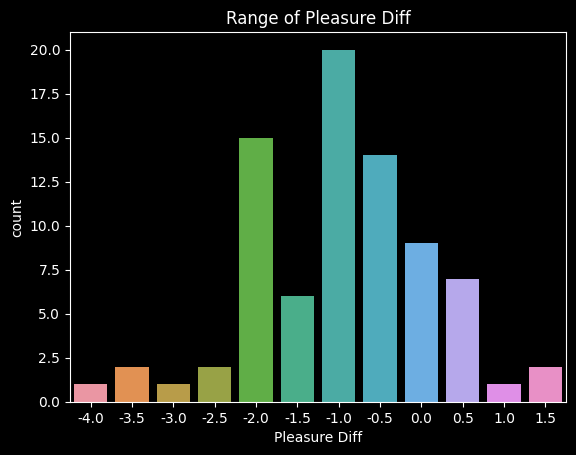

In [ ]:
# a few visualizations to explore the data
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x= 'Pleasure Diff', data=df)
plt.style.use('dark_background')
plt.title('Range of Pleasure Diff')
plt.show()

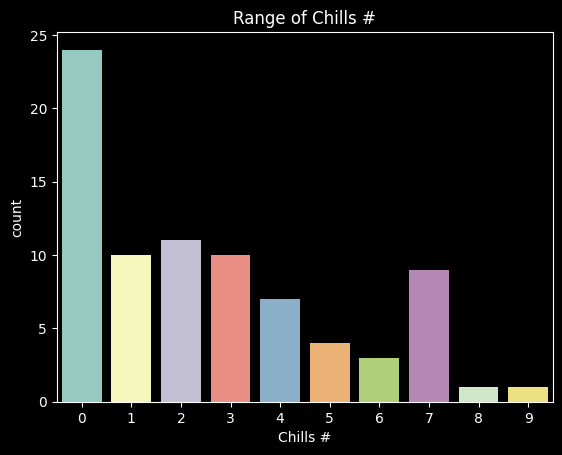

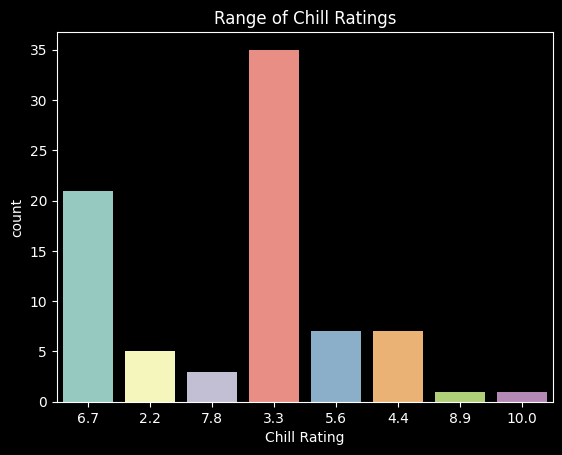

In [ ]:
# Chills # and Chill Rating

sns.countplot(x='Chills #', data=df)
plt.style.use('dark_background')
plt.title('Range of Chills #')
plt.show()

sns.countplot(x='Chill Rating', data=df)
plt.style.use('dark_background')
plt.title('Range of Chill Ratings')
plt.show()


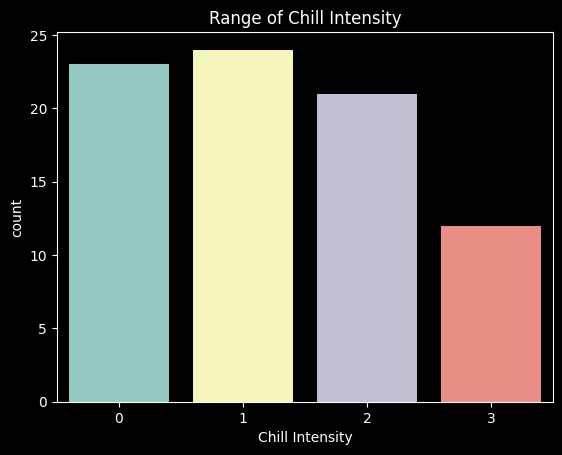

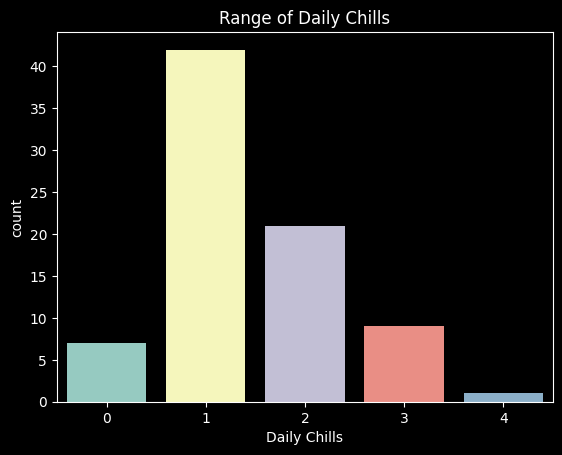

In [ ]:
# A few more
sns.countplot(x='Chill Intensity', data=df)
plt.style.use('dark_background')
plt.title('Range of Chill Intensity')
plt.show()

sns.countplot(x='Daily Chills', data=df)
plt.style.use('dark_background')
plt.title('Range of Daily Chills')
plt.show()

In [ ]:
# Calculate the correlation matrix for your selected columns
selected_columns = ['Chills #', 'Chill Intensity', 'Daily Chills', 'Pleasure Diff', 'Emotion drift', 'Chill Rating']
corr = df[selected_columns].corr()

print(corr)

                     Chills #  Chill Intensity  Daily Chills  Pleasure Diff  \
Chills #         1.000000e+00         0.692152 -7.125541e-17       0.243660   
Chill Intensity  6.921519e-01         1.000000  2.041475e-01       0.280296   
Daily Chills    -7.125541e-17         0.204147  1.000000e+00      -0.277070   
Pleasure Diff    2.436602e-01         0.280296 -2.770701e-01       1.000000   
Emotion drift   -7.990091e-02        -0.155129  6.265514e-02      -0.564080   

                 Emotion drift  
Chills #             -0.079901  
Chill Intensity      -0.155129  
Daily Chills          0.062655  
Pleasure Diff        -0.564080  
Emotion drift         1.000000  


<ipython-input-83-a7164c62bda3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[selected_columns].corr()


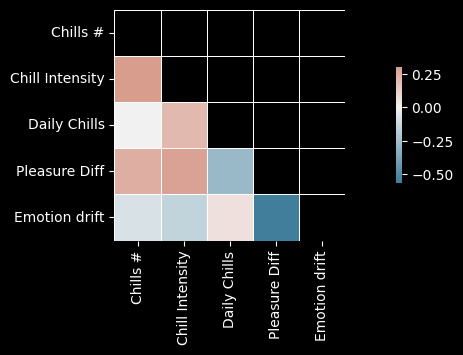

In [ ]:
# Create a grcontour graph of matrix
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [ ]:
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap

# Create a list of unique colors for each circle
colors = [Category10[10][i % 10] for i in range(len(df))]

# Add the colors to your DataFrame
df['colors'] = colors

# Create a new plot with the HoverTool
hover = HoverTool(tooltips=None, mode="vline")
p = figure(tools=[hover, 'wheel_zoom', 'pan'], title="Pleasure Diff and Chill Intensity")

# Add a circle renderer with color mapped to the new 'colors' column
p.circle('Pleasure Diff', 'Chill Intensity', radius=1, fill_color='colors', fill_alpha=0.6,
         line_color=None, source=df)

curdoc().theme = 'dark_minimal'
output_notebook()
show(p)

In [ ]:
# Assuming Pleasure Diff is binary where 1 represents good chills and 0 represents bad chills
good_chills = df[df['Pleasure Diff'] == 1]
bad_chills = df[df['Pleasure Diff'] == 0]

print("Good Chills - Mean Intensity: ", good_chills['Chill Intensity'].mean())
print("Bad Chills - Mean Intensity: ", bad_chills['Chill Intensity'].mean())


Good Chills - Mean Intensity:  2.0
Bad Chills - Mean Intensity:  1.6666666666666667


In [ ]:
# Assuming 'df' is your DataFrame
print("Dataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Video ID                80 non-null     object 
 1   Age                     80 non-null     int64  
 2   Gender                  80 non-null     object 
 3   Ethnicity               80 non-null     object 
 4   chills Binary           80 non-null     bool   
 5   Chills #                80 non-null     int64  
 6   Chill Intensity         80 non-null     int64  
 7   Daily Chills            80 non-null     int64  
 8   NIO_Openess             80 non-null     int64  
 9   Prior exposure          80 non-null     object 
 10  Sleppiness              80 non-null     int64  
 11  Pre-Pleasure            80 non-null     int64  
 12  Prepleasure /2 arrondi  80 non-null     int64  
 13  Prepleasure /2          80 non-null     float64
 14  Post-Pleasure           80

In [ ]:
df.isnull().sum()

Video ID                  0
Age                       0
Gender                    0
Ethnicity                 0
chills Binary             0
Chills #                  0
Chill Intensity           0
Daily Chills              0
NIO_Openess               0
Prior exposure            0
Sleppiness                0
Pre-Pleasure              0
Prepleasure /2 arrondi    0
Prepleasure /2            0
Post-Pleasure             0
Pre Calm                  0
Pre-calm/2                0
Pre-calm/2 (rounded)      0
Post Calm                 0
Pre NEO                   0
Post NEO                  0
Diff NEO                  0
Total NEO                 0
Emotion drift             0
Direction                 0
Tan inverse               0
Calm Diff                 0
Pleasure Diff             0
Tan inverse.1             0
Chill Rating              0
colors                    0
dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create your features matrix (X) by dropping all target variables at once
X = df.drop('Pleasure Diff', axis=1)

# Create your labels matrix (y) by selecting all target variables
y = df['Pleasure Diff']
# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder and transform the categorical data
X_categorical = encoder.fit_transform(X.select_dtypes(include=['object'])).toarray()

# Combine the categorical and numerical data
X_numerical = X.select_dtypes(include=['int64', 'float64']).values
X_preprocessed = np.concatenate([X_numerical, X_categorical], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

# Split the preprocessed data into training and testing sets
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, shuffle=True)

# Train a stochastic gradient descent model
model = SGDRegressor()

# Fit the model to your preprocessed training data
model.fit(X_train_pre, y_train)

# Predict the target for the preprocessed testing set
y_pred = model.predict(X_test_pre)
print(y_test)
print(y_pred)

30    0.0
0    -0.5
22    0.0
31   -1.0
18    0.5
28   -3.5
10   -0.5
70   -0.5
4     0.0
12   -1.0
49   -2.0
33   -1.0
67   -0.5
35   -1.0
68   -0.5
45   -0.5
Name: Pleasure Diff, dtype: float64
[-1.04336083e+12 -5.15138622e+11 -5.52899140e+11 -1.09161453e+12
 -3.28484490e+12 -1.42957521e+12 -2.05150070e+12 -1.72898542e+12
 -1.03245924e+12 -1.91858715e+12 -4.93494741e+11 -9.68937796e+11
 -2.97277130e+12 -1.16257034e+12 -3.05269076e+12 -1.39887295e+12]


In [ ]:
print("Shape of X_preprocessed:", X_preprocessed.shape)
print("Shape of y:", y.shape)
print("Shape of X_train_pre:", X_train_pre.shape)
print("Shape of X_test_pre:", X_test_pre.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_preprocessed: (80, 91)
Shape of y: (80,)
Shape of X_train_pre: (64, 91)
Shape of X_test_pre: (16, 91)
Shape of y_train: (64,)
Shape of y_test: (16,)


In [ ]:
small_subset = X_test_pre[:5]
small_pred = model.predict(small_subset)
print("Shape of small_subset:", small_subset.shape)
print("Shape of small_pred:", small_pred.shape)

Shape of small_subset: (5, 91)
Shape of small_pred: (5,)


In [ ]:
y_pred = model.predict(X_test_pre)
print("Shape of y_pred:", y_pred.shape)

Shape of y_pred: (16,)


In [ ]:
print(y.describe())

count    80.000000
mean     -0.968750
std       1.074279
min      -4.000000
25%      -2.000000
50%      -1.000000
75%      -0.500000
max       1.500000
Name: Pleasure Diff, dtype: float64


In [ ]:
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

Shape of y_test: (16,)
Shape of y_pred: (16,)


In [ ]:
# Extract the 'Pleasure Diff' values from y_test
y_test_values = y_test.values

print(y_test_values)

[ 0.  -0.5  0.  -1.   0.5 -3.5 -0.5 -0.5  0.  -1.  -2.  -1.  -0.5 -1.
 -0.5 -0.5]


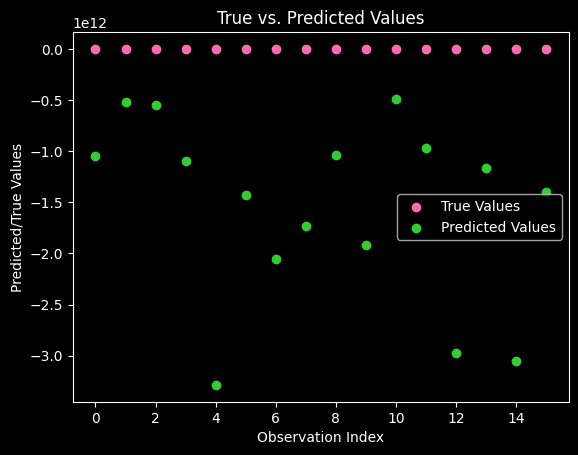

In [ ]:
import matplotlib.pyplot as plt

# Create an array for the sample number or index
index = np.arange(len(y_test_values))

# Scatter plot of the true values
plt.scatter(index, y_test_values, color='hotpink', label='True Values')

# Scatter plot of the predicted values
plt.scatter(index, y_pred, color='limegreen', label='Predicted Values')

plt.xlabel('Observation Index')
plt.ylabel('Predicted/True Values')

plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

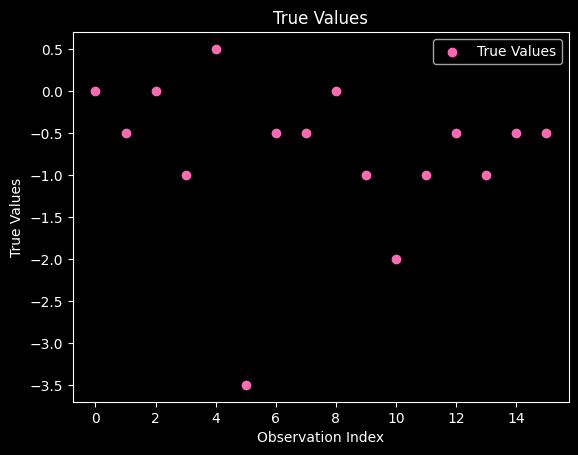

In [ ]:
plt.scatter(index, y_test_values, color='hotpink', label='True Values')
plt.xlabel('Observation Index')
plt.ylabel('True Values')
plt.title('True Values')
plt.legend()
plt.show()

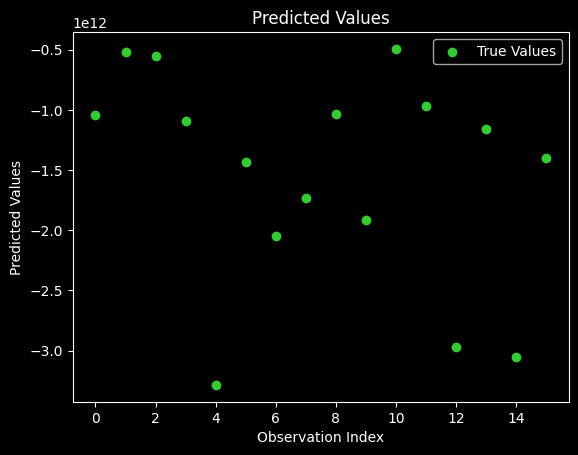

In [ ]:
plt.scatter(index, y_pred, color='limegreen', label='True Values')
plt.xlabel('Observation Index')
plt.ylabel('Predicted Values')
plt.title('Predicted Values')
plt.legend()
plt.show()

In [ ]:
print(y_train.values)

[ 1.5  0.5 -1.  -2.  -2.  -1.  -2.  -2.5  0.  -1.5 -0.5 -1.  -2.   0.
 -1.5  1.  -1.  -0.5 -0.5 -1.  -0.5 -2.  -1.  -4.  -1.  -1.5 -2.  -1.5
 -2.  -2.   0.  -2.  -3.5  1.5 -1.5  0.5 -2.   0.  -1.5 -2.   0.5  0.5
 -3.  -1.  -1.   0.5 -2.   0.  -2.  -1.  -0.5 -0.5 -1.  -0.5 -2.  -2.5
 -1.  -0.5 -1.   0.  -1.  -1.   0.5 -1. ]


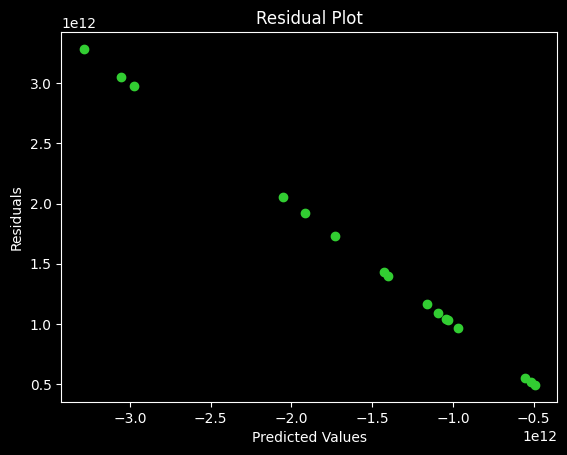

In [ ]:
residuals = y_test_values - y_pred
plt.scatter(y_pred, residuals, color='limegreen')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

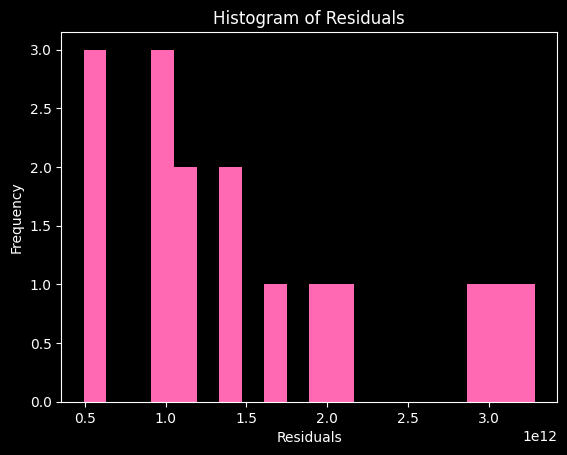

In [ ]:
plt.hist(residuals, bins=20, color='hotpink')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(y_test_values, y_pred)
mse = mean_squared_error(y_test_values, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1543643976942.469
Mean Squared Error (MSE): 3.142328625821149e+24
Root Mean Squared Error (RMSE): 1772661452681.01


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns
df_selected = df[['Pleasure Diff']]

# Fill any missing values
df_selected.fillna(method='ffill', inplace=True)

# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_selected)

# Convert the DataFrame to a 3D array for LSTM
# The shape should be (number of samples, 1, number of features)
df_reshaped = np.reshape(df_scaled, (df_scaled.shape[0], 1, df_scaled.shape[1]))

<ipython-input-104-6548cf1f7f5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(method='ffill', inplace=True)


In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(df_reshaped.shape[1], df_reshaped.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam', metrics='accuracy')

# Train the model
history = model.fit(df_reshaped, df['Pleasure Diff'], epochs=50, batch_size=72, validation_split=0.2, verbose=0, shuffle=False)

3/3 [==============================] - 1s 6ms/step


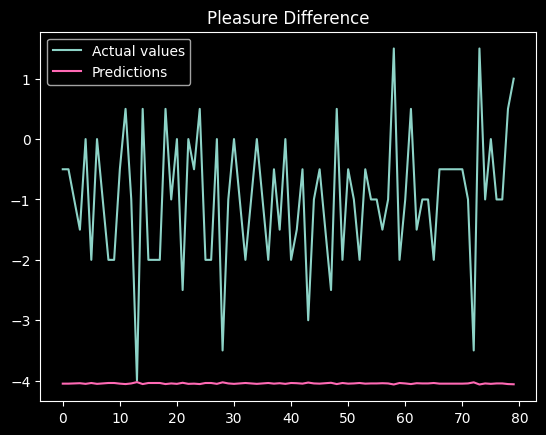

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler for the target variable
scaler_target = MinMaxScaler(feature_range=(0, 1))
df_target_scaled = scaler_target.fit_transform(df[['Pleasure Diff']])

# Train the model
history = model.fit(df_reshaped, df_target_scaled, epochs=50, batch_size=72, validation_split=0.2, verbose=0, shuffle=False)

# Make predictions
predictions = model.predict(df_reshaped)

# Invert scaling for the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Plot the actual values vs the predictions
plt.plot(df['Pleasure Diff'].values, label='Actual values')
plt.plot(predictions_rescaled, label='Predictions',color='hotpink')
plt.title('Pleasure Difference')
plt.legend()
plt.show()